In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering


you have to figure out how you can use the work iarantsoa did in this file + change this:<br>
user_style_matrix_scaled<br>
to adapt to what she has

In [2]:
df = pd.read_csv('../../knnData/BA_US_knn_text.csv')

(6331638, 17)
(1829363, 10)
   abv  appearance  taste    rating  style_Altbier  \
0 -0.5         0.0  -0.50 -0.313433            0.0   
1 -0.5        -1.0  -0.75 -1.014925            0.0   
2 -0.5        -2.0  -0.50 -0.955224            0.0   
3 -0.5         0.0   0.00  0.134328            0.0   
4 -0.5         0.0   0.50  0.731343            0.0   

   style_American Adjunct Lager  style_American Amber / Red Ale  \
0                           0.0                             0.0   
1                           0.0                             0.0   
2                           0.0                             0.0   
3                           0.0                             0.0   
4                           0.0                             0.0   

   style_American Amber / Red Lager  style_American Barleywine  \
0                               0.0                        0.0   
1                               0.0                        0.0   
2                               0.0           

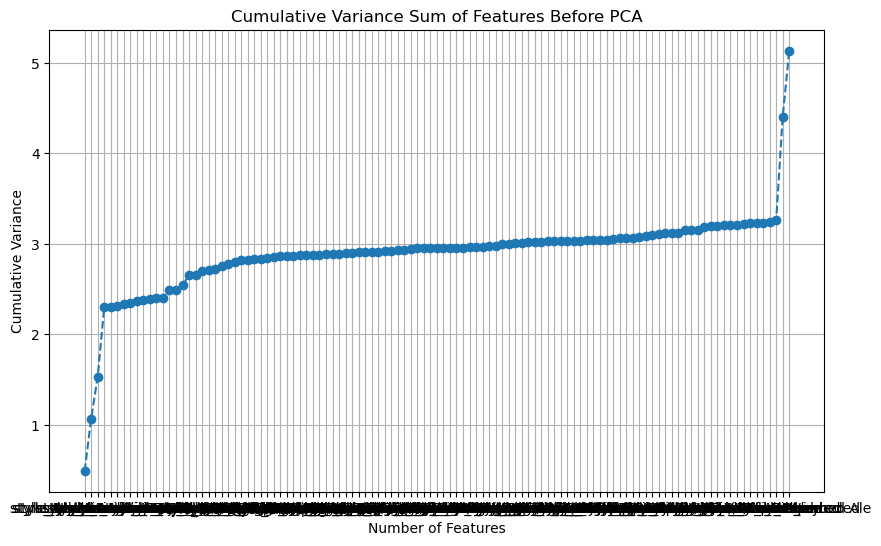

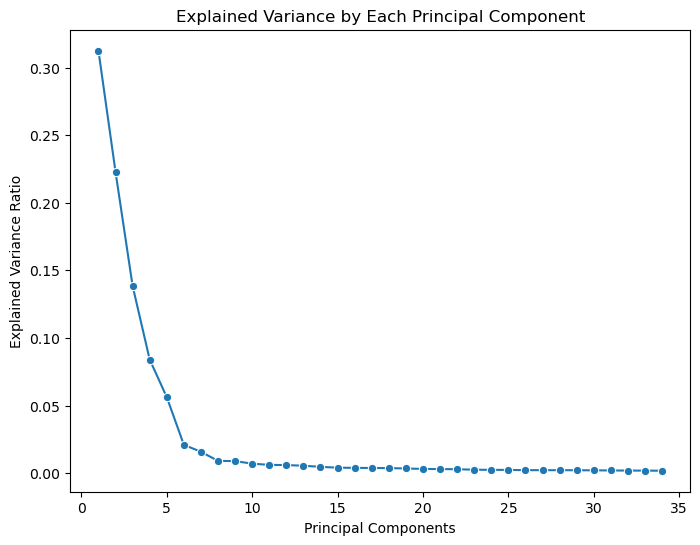

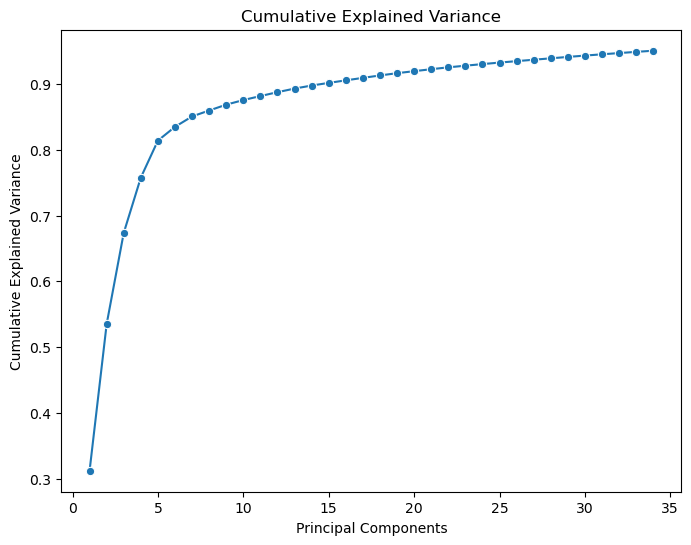

PCA transformed data saved as 'pca_transformed_data.csv'
Shape of the DataFrame: (1829363, 34)


In [3]:
%run param_selec.ipynb

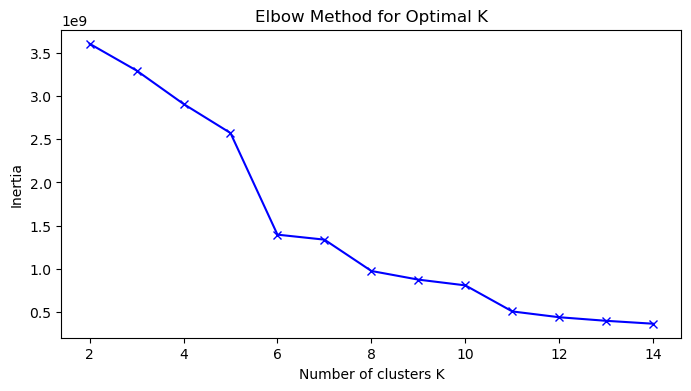

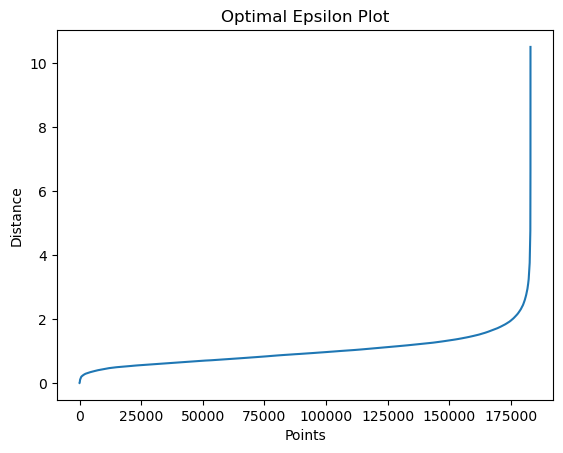

In [4]:
#======================================
#IMPUTATION
#======================================

'''
iter_imputer = IterativeImputer(random_state=42)
X_iter_imputed = pd.DataFrame(iter_imputer.fit_transform(X), columns=X.columns)

print(X_iter_imputed.isnull().sum())
'''
#======================================
#SCALING
#======================================

#scaler = StandardScaler()
scaler = RobustScaler()
#scaler = MinMaxScaler()
#you use this one if the iterative imputer is running
#X_scaled = pd.DataFrame(scaler.fit_transform(X_iter_imputed), columns=X_iter_imputed.columns)
X_scaled = pd.DataFrame(scaler.fit_transform(X_pca_df), columns=X_pca_df.columns)

#======================================
#IMPROVEMENTS ON CLUSTERING
#======================================

#KMEANS
inertia = []
K_range = range(2, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Number of clusters K')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

#DBSCAN
X_subset = X_scaled.sample(frac=0.1, random_state=42)  # Use 10% of the data

from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_subset)
distances, indices = neighbors_fit.kneighbors(X_subset)

distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.title("Optimal Epsilon Plot")
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()

In [5]:

#======================================
#K MEANS CLUSTERING
#======================================
'''
optimal_k = 5
#kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans = KMeans(n_clusters=optimal_k, n_init=50, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)
X_scaled['cluster'] = cluster_labels

#silhouette_avg = silhouette_score(X_scaled.drop('cluster', axis=1), cluster_labels)
#print(f'Silhouette Score for K={optimal_k}: {silhouette_avg}')
'''
#======================================
#DBSCAN
#======================================

dbscan = DBSCAN(eps=1.5, min_samples=5, n_jobs=-1)  
cluster_labels = dbscan.fit_predict(X_scaled)
X_scaled['cluster'] = cluster_labels

#======================================
#AGGLOMERATIVE CLUSTERING
#======================================
'''
agglo = AgglomerativeClustering(n_clusters=5, linkage='ward')
cluster_labels = agglo.fit_predict(X_scaled)
X_scaled['cluster'] = cluster_labels
'''


"\nagglo = AgglomerativeClustering(n_clusters=5, linkage='ward')\ncluster_labels = agglo.fit_predict(X_scaled)\nX_scaled['cluster'] = cluster_labels\n"

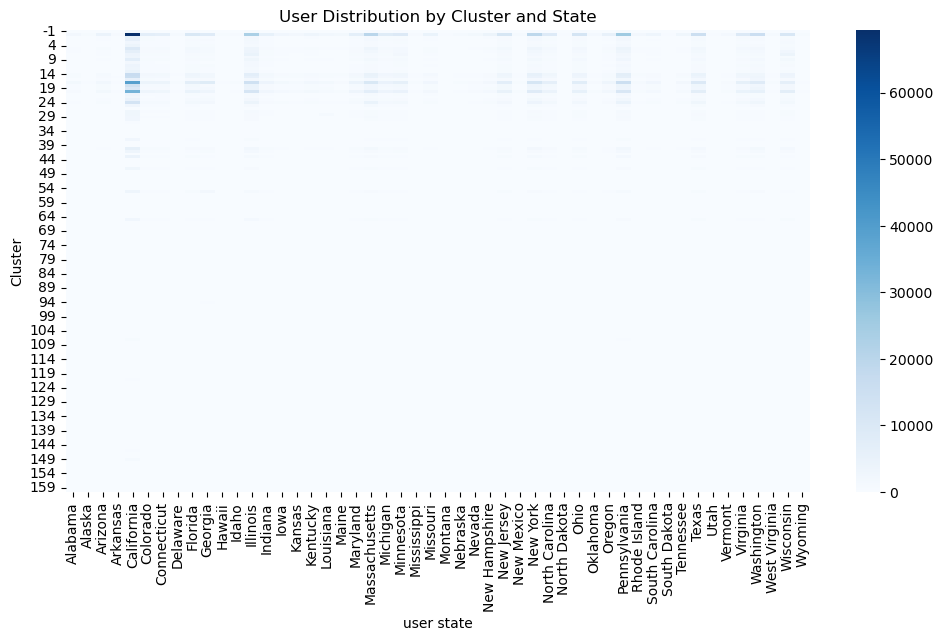

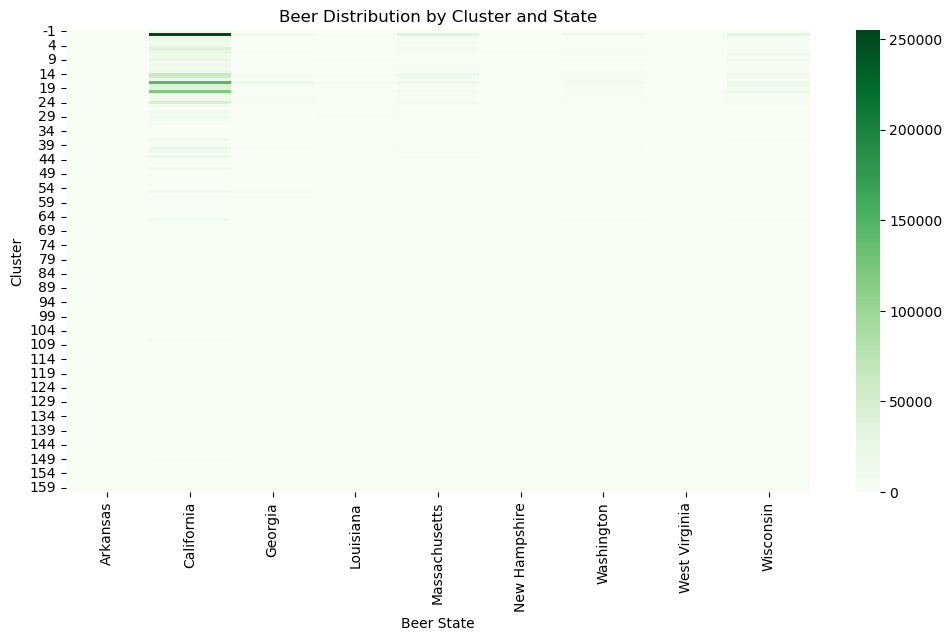

In [10]:
cluster_labels_df = X_scaled[['cluster']].reset_index(drop=True)
#you can use this (down) when the itreative imputer is able to run
#cluster_labels_df['user_id'] = df['user_id'].values
#cluster_labels_df['beer_id'] = df['beer_id'].values
cluster_labels_df['user_id'] = df.loc[X_pca_df.index, 'user_id'].values
cluster_labels_df['beer_id'] = df.loc[X_pca_df.index, 'beer_id'].values


cluster_labels_df = cluster_labels_df.merge(
    df[['user_id', 'user_state']].drop_duplicates(),
    on='user_id',
    how='left'
)

if 'beer_id' in df.columns:
    cluster_labels_df = cluster_labels_df.merge(
        df[['beer_id', 'beer_state']].drop_duplicates(),
        on='beer_id',
        how='left'
    )

user_cluster_state_counts = cluster_labels_df.groupby(['cluster', 'user_state']).size().unstack(fill_value=0)

if 'beer_state' in cluster_labels_df.columns:
    beer_cluster_state_counts = cluster_labels_df.groupby(['cluster', 'beer_state']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(user_cluster_state_counts, annot=False, fmt='d', cmap='Blues')
plt.title('User Distribution by Cluster and State')
plt.xlabel('user state')
plt.ylabel('Cluster')
plt.show()

if 'beer_state' in cluster_labels_df.columns:
    plt.figure(figsize=(12, 6))
    sns.heatmap(beer_cluster_state_counts, annot=False, fmt='d', cmap='Greens')
    plt.title('Beer Distribution by Cluster and State')
    plt.xlabel('Beer State')
    plt.ylabel('Cluster')
    plt.show()


In [17]:
'''
cluster_totals = user_cluster_state_counts_t.sum(axis=0)

for cluster_label, cluster_data in user_cluster_state_counts_t.items():
    # Get the top 5 states for the current cluster
    top_states = cluster_data.nlargest(5).index
    
    # Print the cluster label and its top 5 states
    print(f"Cluster {cluster_label}: {', '.join(top_states)}")
'''

state_totals = user_cluster_state_counts_t.sum(axis=1)
#print(state_totals)

normalized_cluster_data = user_cluster_state_counts_t.div(state_totals, axis=0)

for cluster_label, cluster_data in normalized_cluster_data.items():
    top_states = cluster_data.nlargest(10).index
    print(f"Cluster {cluster_label}: {', '.join(top_states)}")

Cluster -1: North Dakota, Delaware, Nebraska, Mississippi, Arkansas, Hawaii, Rhode Island, Oregon, Alabama, Vermont
Cluster 0: New Mexico, Massachusetts, Montana, Washington, Rhode Island, New Hampshire, California, New Jersey, Alaska, Oregon
Cluster 1: Wyoming, Alaska, Louisiana, Oregon, Colorado, Vermont, Montana, Arizona, Utah, Pennsylvania
Cluster 2: Montana, Hawaii, Georgia, Colorado, Wyoming, West Virginia, California, South Carolina, Pennsylvania, Utah
Cluster 3: Wisconsin, Illinois, Montana, Iowa, Vermont, Minnesota, Wyoming, South Dakota, Utah, Missouri
Cluster 4: Utah, Delaware, Maine, Virginia, Hawaii, Pennsylvania, Arizona, North Carolina, Idaho, New York
Cluster 5: Hawaii, Maine, Utah, Massachusetts, Connecticut, Rhode Island, Alaska, Idaho, New Hampshire, New York
Cluster 6: Wisconsin, Minnesota, New Hampshire, South Dakota, West Virginia, Illinois, Montana, Connecticut, Rhode Island, Tennessee
Cluster 7: Wisconsin, Minnesota, Illinois, Iowa, Indiana, Alaska, South Dakota

/home/belgie/anaconda3/envs/ada/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


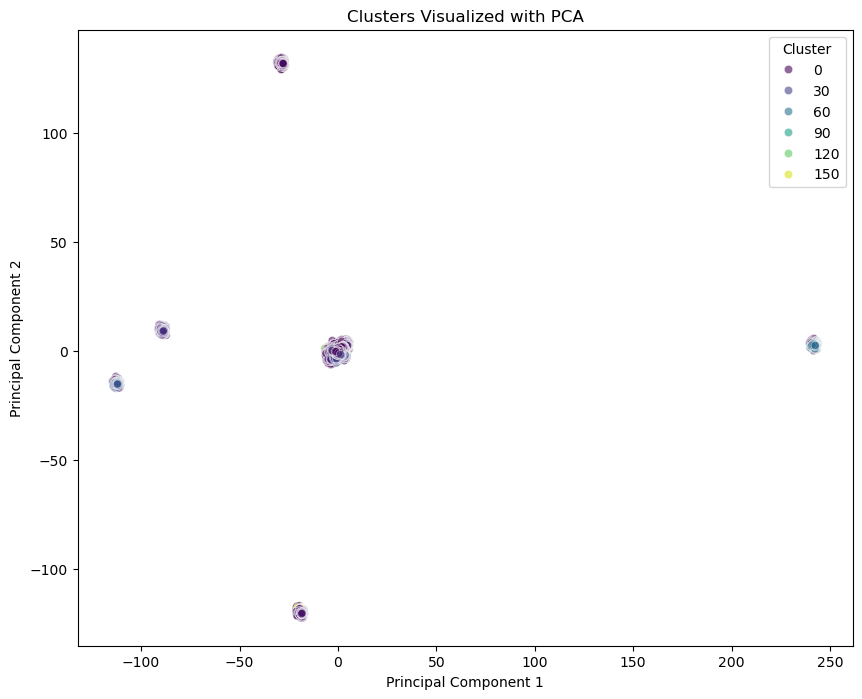

Explained Variance by PC1: 0.40
Explained Variance by PC2: 0.16


In [14]:
features = X_scaled.drop('cluster', axis=1)

pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(features)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster',
    palette='viridis',
    data=pca_df,
    alpha=0.6
)
plt.title('Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()
explained_variance = pca.explained_variance_ratio_
print(f'Explained Variance by PC1: {explained_variance[0]:.2f}')
print(f'Explained Variance by PC2: {explained_variance[1]:.2f}')
